In [34]:
import sys
sys.path.append("../../analysis")

import warnings
from math import sqrt
import pandas as pd
import matplotlib.pyplot as plt
from pyomo.environ import *

from classes import NFPO

%matplotlib inline

warnings.simplefilter('ignore')

In [35]:
tag_population = 5
tags_number = range(tag_population)
tags_space = 0.1
frequency_mhz_list = [916.8, 918.0, 919.2, 920.4]
frequency_list = [frequency_mhz * 10**6 for frequency_mhz in frequency_mhz_list]
light_speed = 2.998e8
wave_length_list = [light_speed / frequency for frequency in frequency_list]
sample_count = 100

In [36]:
data_set = {}
columns = ["rssi","phase","samplingNumber"]
for x in range(0, 51, 50):
    for y in range(100,201,100):
        coor_df = {}
        coor_np = {}
        for frequency_mhz in frequency_mhz_list:
            df = pd.read_csv(f"../data/nfpo_pdoa/{x}-{y}.csv")
            df2 = df[(df["tagNumber"] == 0) & (df["frequency"] == frequency_mhz)][columns].rename(
                columns={
                    "rssi": f"tag{0}_rssi",
                    "phase": f"tag{0}_phase"
                }
            )[:sample_count].reset_index().drop("index", axis=1)
            for i in range(1, tag_population):
                merged_df = df[(df["tagNumber"] == i) & (df["frequency"] == frequency_mhz)][columns].rename(
                    columns={
                        "rssi": f"tag{i}_rssi",
                        "phase": f"tag{i}_phase"
                    }
                )[:sample_count].reset_index().drop("index", axis=1)
                df2 = pd.concat([df2, merged_df], axis=1)
            coor_df[f"{frequency_mhz}MHz"]=df2
            coor_np[f"{frequency_mhz}MHz"]=df2[[f"tag{t}_phase" for t in range(tag_population)]][:sample_count].to_numpy()
            # print(f"{x/100}, {y/100}, {frequency_mhz}")
            # print(coor_np[f"{frequency_mhz}MHz"])
        data_set[f"{x/100}-{y/100}"]={
            "actual_coordinate":{"x":x/100, "y":y/100},
            "df": coor_df,
            "phase_np": coor_np,
            "rssi_np": df2[[f"tag{t}_rssi" for t in range(tag_population)]].to_numpy()
        }

In [37]:
result_dict = {}
for x in range(0, 51, 50):
    result_dict[str(x)]={}
    for y in range(100,201,100):
        err_fre = []
        for i in range(0,4):
            frequency_mhz = frequency_mhz_list[i]
            frequency = frequency_list[i]
            wave_length = wave_length_list[i]
            nfpo = NFPO(
                sample_count=sample_count,
                tags_space=tags_space,
                phases=data_set[f"{x/100}-{y/100}"]["phase_np"][f"{frequency_mhz}MHz"],
                tag_population=5,
                wave_length=wave_length,
                tag_location={"x":0,"y":1},
                initial_value={"x":0,"y":1},
                x_err_range=2,
                y_err_range=1,
            )
            result = nfpo.solve()
            err = sqrt((x/100-result["values"]["x"])**2+(y/100-result["values"]["y"])**2)
            err_fre.append(err)
        result_dict[str(x)][str(y)]=err_fre

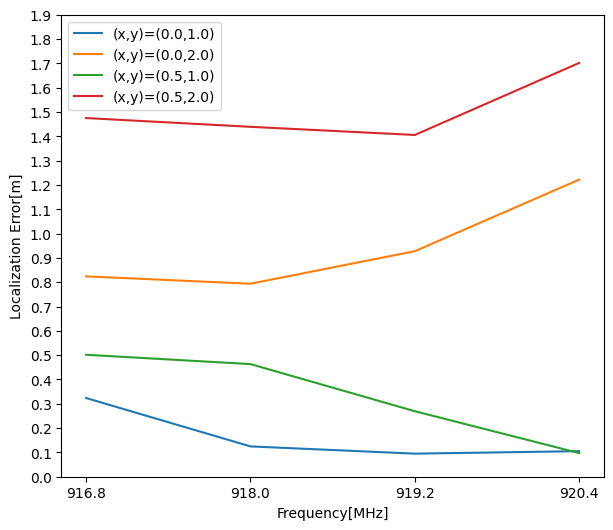

In [42]:
fig, ax = plt.subplots(figsize=(7,6))
for x in range(0, 51, 50):
    for y in range(100,201,100):
        ax.plot(frequency_list, result_dict[str(x)][str(y)], label=f"(x,y)=({x/100},{y/100})")
ax.set_xlabel("Frequency[MHz]")
ax.set_ylabel("Localization Error[m]")
ax.set_xticks(frequency_list)
ax.set_xticklabels(frequency_mhz_list)
ax.set_yticks([0.1*i for i in range(0,20)])
ax.legend()
fig.show()